# Recommender system

## Loading data

In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf

tf.disable_v2_behavior()
film_columns = ['movie_id', 'movie_title', 'release_date', 'video_release_date', 'imdb_url', 
                'unknown', 'action', 'adventure', 'animation', 'children', 'comedy', 'crime', 
                'documentary', 'drama', 'fantasy', 'film-noir', 'horror', 'musical', 'mystery', 
                'romance', 'sci-fi', 'thriller', 'war', 'western']
films = pd.read_csv('u.item', sep='[|]', names=film_columns, engine='python')
film_names = films[['movie_id', 'movie_title']]
film_genres = films.drop(columns=['movie_id', 'movie_title', 'release_date', 'video_release_date', 
                          'imdb_url'])
film_genres.head()


Instructions for updating:
non-resource variables are not supported in the long term


,unknown,action,adventure,animation,children,comedy,crime,documentary,drama,fantasy,film-noir,horror,musical,mystery,romance,sci-fi,thriller,war,western
0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [2]:
data_columns = ['user_id', 'movie_id', 'rating', 'timestamp']
data = pd.read_csv('u.data', sep='\t', names=data_columns)
data = data.drop(columns='timestamp')
data.head()


,user_id,movie_id,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


In [3]:
user_columns = ['user_id', 'age', 'gender', 'occupation', 'zip_code']
users = pd.read_csv('u.user', sep='[|]', names=user_columns, engine='python')
users = users.drop(columns='zip_code')
users.head()


,user_id,age,gender,occupation
0,1,24,M,technician
1,2,53,F,other
2,3,23,M,writer
3,4,24,M,technician
4,5,33,F,other


## Elbow method for optimal number of clusters and films clustering

In [4]:
def ElbowMethod(data):
    distortion = []
    K = range(1, 25)
    for k in K:
        kmeanModel = KMeans(n_clusters=k, random_state=42)
        kmeanModel.fit(data)
        distortion.append(kmeanModel.inertia_)

    plt.plot(K, distortion, 'bx-')
    plt.xlabel('K')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k for films')
    plt.show()


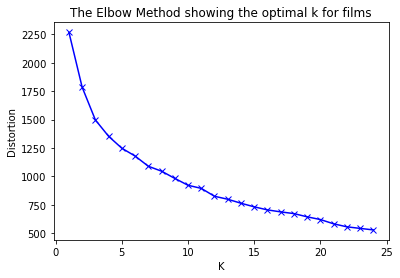

In [5]:
ElbowMethod(film_genres)

# clustering films
kmeans = KMeans(n_clusters=12, random_state=42).fit(film_genres)


## Method for finding films from a certain cluster that are not rated by the user

In [6]:
def NotRatedFilms(cluster_id, labels, user_id, data, film_id):
    # films from same cluster (indexes of the array elements)
    films_from_cluster = [i for i, e in enumerate(labels) if e == cluster_id and i != film_id - 1]
    # increment indexes to get ids of the films
    films_from_cluster = [x + 1 for x in films_from_cluster]
    
    # films from the cluster rated by the user
    rated = data[(data.user_id == user_id) & (data.movie_id.isin(films_from_cluster))]
    rated_films = rated['movie_id'].values
    
    recommended = []
    for i in films_from_cluster:
        if i not in rated_films:
            recommended.append(i)
    
    return recommended


## Recommending films to a user based on currently watching

In [7]:
user_id = 6
film_id = 94

# find cluster to which film belongs
cluster = kmeans.labels_[film_id - 1]

# recommend films from the same cluster
recommended = NotRatedFilms(cluster, kmeans.labels_, user_id, data, film_id)

print("Recommended films from cluster " + str(cluster) + ":")
for i in range(0, 10):
    print(films['movie_title'].values[recommended[i] - 1])


Recommended films from cluster 1:
Birdcage, The (1996)
Brothers McMullen, The (1995)
To Wong Foo, Thanks for Everything! Julie Newmar (1995)
Billy Madison (1995)
Clerks (1994)
Santa Clause, The (1994)
Ace Ventura: Pet Detective (1994)
Mask, The (1994)
Maverick (1994)
Hot Shots! Part Deux (1993)


## Recommending films from the best rated cluster for a user

In [8]:
pd.options.mode.chained_assignment = None
# adding cluster column to films data frame
film_names['cluster'] = kmeans.labels_

# selecting rated films by the user
rated_films = data[data.user_id == user_id]

# combining rated films with cluster number
rated_films_clusters = pd.merge(rated_films, film_names, on='movie_id')

# calculating average rating for each cluster
cluster_ratings = rated_films_clusters.groupby(['cluster'], as_index=False)['rating'].mean()

cluster_ratings


,cluster,rating
0,0,3.785714
1,1,3.324324
2,2,3.619718
3,3,4.000000
4,4,3.800000
5,5,3.000000
6,6,4.555556
7,7,3.750000
8,8,4.333333
9,9,4.333333


In [9]:
# get best rated cluster
best_rated_cluster = cluster_ratings['cluster'].values[cluster_ratings['rating'].idxmax()]

# recommending films from the best rated cluster
recommended = NotRatedFilms(best_rated_cluster, kmeans.labels_, user_id, data, -1)

print("Recommended films from cluster " + str(best_rated_cluster) + ":")
for i in range(0, 5):
    print(films['movie_title'].values[recommended[i] - 1])


Recommended films from cluster 6:
Basic Instinct (1992)
Absolute Power (1997)
Devil's Advocate, The (1997)
Murder at 1600 (1997)
Lost Highway (1997)


## Recommending similar movies using matrix factorization

In [10]:
# build a utility matrix with a value for each user and each movie (0 if not rated)
rating_crosstab = data.pivot_table(values='rating', index='user_id', columns='movie_id', 
                                   fill_value=0)
# transpose matrix so that movies are represented by rows
film_rating = rating_crosstab.T

film_rating.head()


user_id,1,2,3,4,5,6,7,8,9,10,...,934,935,936,937,938,939,940,941,942,943
movie_id,,,,,,,,,,,,,,,,,,,,,
1,5,4,0,0,4,4,0,0,0,4,...,2,3,4,0,4,0,0,5,0,0
2,3,0,0,0,3,0,0,0,0,0,...,4,0,0,0,0,0,0,0,0,5
3,4,0,0,0,0,0,0,0,0,0,...,0,0,4,0,0,0,0,0,0,0
4,3,0,0,0,0,0,5,0,0,4,...,5,0,0,0,0,0,2,0,0,0
5,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
# use singular value decomposition
SVD = TruncatedSVD(n_components=12, algorithm='arpack')

# use fit method to perform SVD on 'film_rating'
resultant_matrix = SVD.fit_transform(film_rating.astype(float))

# calculate Pearson correlation for all movies
corr_mat = np.corrcoef(resultant_matrix)

corr_mat[:5, :5]


array([[1.        , 0.80348409, 0.82209388, 0.74446451, 0.592839  ],
       [0.80348409, 1.        , 0.67937464, 0.87848235, 0.72041463],
       [0.82209388, 0.67937464, 1.        , 0.73584556, 0.72864633],
       [0.74446451, 0.87848235, 0.73584556, 1.        , 0.7476189 ],
       [0.592839  , 0.72041463, 0.72864633, 0.7476189 , 1.        ]])

In [12]:
# recommend movies related to a certain movie
# extract correlation of film
corr_film = corr_mat[film_id - 1]

# generate a list of movie names that have a high degree of correlation with target
print("Recommended films:")
list(films['movie_title'].values[(corr_film < 1.0) & (corr_film > 0.95)])


Recommended films:


['Santa Clause, The (1994)',
 'Mask, The (1994)',
 'Maverick (1994)',
 'Home Alone (1990)',
 'Mrs. Doubtfire (1993)',
 'Three Musketeers, The (1993)',
 "City Slickers II: The Legend of Curly's Gold (1994)",
 'Son in Law (1993)',
 'Renaissance Man (1994)']

## Recommending movies using kNN (cold start problem solving)

In [13]:
genres = ['action', 'adventure', 'crime', 'mystery']
target = film_genres[genres]

# use fit method to create model
neighbors = NearestNeighbors(n_neighbors=10).fit(target)

# films rated by the user
rated = data[(data.user_id == user_id)]
rated_films = rated['movie_id'].values

# check the recommendation by model
print("Recommended films:")
for i in neighbors.kneighbors([[1, 1, 1, 1]], return_distance=False)[0]:
    if i+1 not in rated_films:
        print(films['movie_title'].values[i])


Recommended films:
Batman Forever (1995)
U Turn (1997)
Hard Target (1993)
Congo (1995)
Rumble in the Bronx (1995)
Batman & Robin (1997)
Cliffhanger (1993)
Batman Returns (1992)
Batman (1989)


## Solving cold start problem using Random forest

In [14]:
# combining rated films with cluster numbers
rated_films_clusters = pd.merge(data, film_names, on='movie_id')

# calculating average rating for each user and cluster
cluster_ratings = rated_films_clusters.groupby(['user_id', 'cluster'], as_index=False)['rating']\
    .mean()

cluster_ratings.head()


,user_id,cluster,rating
0,1,0,3.416667
1,1,1,3.411765
2,1,2,4.118644
3,1,3,4.800000
4,1,4,3.888889


In [15]:
# finding best rated cluster for each user
idx = cluster_ratings.groupby(['user_id'], as_index=False)['rating'].idxmax()
cluster_ratings = cluster_ratings.loc[idx]

# combine user info and best rated cluster info
users_clusters = pd.merge(users, cluster_ratings, on='user_id')
users_clusters = users_clusters.drop(columns=['user_id', 'rating'])

users_clusters.head()


,age,gender,occupation,cluster
0,24,M,technician,3
1,53,F,other,7
2,23,M,writer,3
3,24,M,technician,1
4,33,F,other,6


In [16]:
# change categorical information into numerical information
categorical_features = ['gender', 'occupation']
for col in categorical_features:
        one_hot = pd.get_dummies(users_clusters[col])
        column_list = []
        for c in one_hot.columns:
            column_list.append(col + '_' + str(c))
        one_hot.columns = column_list
        users_clusters = users_clusters.drop(columns=col)
        users_clusters = users_clusters.join(one_hot)

users_clusters.head()


,age,cluster,gender_F,gender_M,occupation_administrator,occupation_artist,occupation_doctor,occupation_educator,occupation_engineer,occupation_entertainment,...,occupation_marketing,occupation_none,occupation_other,occupation_programmer,occupation_retired,occupation_salesman,occupation_scientist,occupation_student,occupation_technician,occupation_writer
0,24,3,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,53,7,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,23,3,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,24,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,33,6,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [17]:
# assign input and output variables
X = users_clusters.drop(columns='cluster')
y = users_clusters['cluster']

# create an instance of the classifier
rfc = RandomForestClassifier(n_estimators=800)

# fit the model on training set
rfc.fit(X, y)

# make prediction
user = [23, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]

# predict cluster for user and recommend films from it
prediction = rfc.predict([user])
recommended = NotRatedFilms(prediction, kmeans.labels_, -1, data, -1)

print("Recommended films from cluster " + str(prediction[0]) + ":")
for i in range(0, 10):
    print(films['movie_title'].values[recommended[i] - 1])


Recommended films from cluster 4:
French Twist (Gazon maudit) (1995)
I.Q. (1994)
While You Were Sleeping (1995)
Forrest Gump (1994)
Four Weddings and a Funeral (1994)
Hudsucker Proxy, The (1994)
Much Ado About Nothing (1993)
Sleepless in Seattle (1993)
So I Married an Axe Murderer (1993)
Truth About Cats & Dogs, The (1996)


## Using tensorflow and autoencoder to predict missing ratings

In [18]:
num_users = data.user_id.nunique()
num_movies = data.movie_id.nunique()

# normalize ratings [0,1]
ratings = data['rating'].values.astype(float)
min_max_scaler = preprocessing.MinMaxScaler()
scaled = min_max_scaler.fit_transform(ratings.reshape(-1, 1))
scaled = pd.DataFrame(scaled)
data['rating'] = scaled
data.head()

,user_id,movie_id,rating
0,196,242,0.50
1,186,302,0.50
2,22,377,0.00
3,244,51,0.25
4,166,346,0.00


In [19]:
# convert data frame into a matrix for model training
matrix = data.pivot_table(values='rating', index='user_id', columns='movie_id', 
                          fill_value=0)

users = matrix.index.tolist()
movies = matrix.columns.tolist()

matrix = matrix.values
matrix[:5, :5]

array([[1.  , 0.5 , 0.75, 0.5 , 0.5 ],
       [0.75, 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.75, 0.5 , 0.  , 0.  , 0.  ]])

In [20]:
# set up network parameters
num_input = num_movies

# two hidden layers
num_hidden_1 = 10
num_hidden_2 = 5

# X is used to feed training examples
X = tf.placeholder(tf.float64, [None, num_input])

weights = {
    'encoder_h1': tf.Variable(tf.random_normal([num_input, num_hidden_1], dtype=tf.float64)),
    'encoder_h2': tf.Variable(tf.random_normal([num_hidden_1, num_hidden_2], dtype=tf.float64)),
    'decoder_h1': tf.Variable(tf.random_normal([num_hidden_2, num_hidden_1], dtype=tf.float64)),
    'decoder_h2': tf.Variable(tf.random_normal([num_hidden_1, num_input], dtype=tf.float64)),
}

biases = {
    'encoder_b1': tf.Variable(tf.random_normal([num_hidden_1], dtype=tf.float64)),
    'encoder_b2': tf.Variable(tf.random_normal([num_hidden_2], dtype=tf.float64)),
    'decoder_b1': tf.Variable(tf.random_normal([num_hidden_1], dtype=tf.float64)),
    'decoder_b2': tf.Variable(tf.random_normal([num_input], dtype=tf.float64)),
}

In [21]:
# building encoder
def encoder(x):
    # encoder hidden layer 1 with sigmoid activation
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h1']), biases['encoder_b1']))
    # encoder hidden layer 2 with sigmoid activation
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['encoder_h2']), biases['encoder_b2']))
    return layer_2

In [22]:
# building decoder
def decoder(x):
    # decoder hidden layer 1 with sigmoid activation
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['decoder_h1']), biases['decoder_b1']))
    # decoder hidden layer 2 with sigmoid activation
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['decoder_h2']), biases['decoder_b2']))
    return layer_2

In [23]:
# construct model
encode = encoder(X)
decode = decoder(encode)

# predictions and targets
y_pred = decode
y_true = X

In [24]:
# loss function and optimizer
loss = tf.losses.mean_squared_error(y_true, y_pred)
optimizer = tf.train.RMSPropOptimizer(learning_rate=0.03).minimize(loss)

predictions = pd.DataFrame()

# initializers for variables
init = tf.global_variables_initializer()
local_init = tf.local_variables_initializer()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [25]:
with tf.Session() as session:
    # model will be fed 100 times with 25 users
    epochs = 100
    batch_size = 25

    session.run(init)
    session.run(local_init)

    num_batches = int(matrix.shape[0] / batch_size)
    matrix = np.array_split(matrix, num_batches)
    
    for i in range(epochs):

        avg_loss = 0

        for batch in matrix:
            _, l = session.run([optimizer, loss], feed_dict={X: batch})
            avg_loss += l

        avg_loss /= num_batches

        print("Epoch: {} Loss: {}".format(i + 1, avg_loss))
    
    matrix = np.concatenate(matrix, axis=0)

    # reconstruct original ratings
    predict = session.run(decode, feed_dict={X: matrix})
    predictions = predictions.append(pd.DataFrame(predict))
    
    # format data
    predictions = predictions.stack().reset_index(name='rating')
    predictions.columns = ['user_id', 'movie_id', 'rating']
    predictions['user_id'] = predictions['user_id'].map(lambda value: users[value])
    predictions['movie_id'] = predictions['movie_id'].map(lambda value: movies[value])
    
    # remove ratings that are in training set, keep predicted ratings only (top 10)
    keys = ['user_id', 'movie_id']
    index1 = predictions.set_index(keys).index
    index2 = data.set_index(keys).index

    recommendations = predictions[~index1.isin(index2)]
    recommendations = pd.merge(recommendations, film_names, on='movie_id')
    # recommendations = recommendations.drop(columns='cluster')
    recommendations = recommendations.sort_values(['user_id', 'rating'],
                                                  ascending=[True, False])
    recommendations = recommendations.groupby('user_id').head(10)

Epoch: 1 Loss: 0.3373079332145485
Epoch: 2 Loss: 0.33453579770552144
Epoch: 3 Loss: 0.31352845559249054
Epoch: 4 Loss: 0.26722575522757863
Epoch: 5 Loss: 0.18693939032586845
Epoch: 6 Loss: 0.04324866297679979
Epoch: 7 Loss: 0.026833906971119547
Epoch: 8 Loss: 0.025967189060473763
Epoch: 9 Loss: 0.02565888614972701
Epoch: 10 Loss: 0.02539309743489768
Epoch: 11 Loss: 0.024472630003819596
Epoch: 12 Loss: 0.023393981007708085
Epoch: 13 Loss: 0.02244977159677325
Epoch: 14 Loss: 0.022066995904252335
Epoch: 15 Loss: 0.021837451772109884
Epoch: 16 Loss: 0.021667642569219745
Epoch: 17 Loss: 0.021549730486161
Epoch: 18 Loss: 0.021472288069088716
Epoch: 19 Loss: 0.021386017796356935
Epoch: 20 Loss: 0.021304182708263397
Epoch: 21 Loss: 0.021256337697441514
Epoch: 22 Loss: 0.021226388553308474
Epoch: 23 Loss: 0.021159918399880063
Epoch: 24 Loss: 0.021114380300246382
Epoch: 25 Loss: 0.021049104605776234
Epoch: 26 Loss: 0.021006053137416776
Epoch: 27 Loss: 0.02097848551096143
Epoch: 28 Loss: 0.020926

In [26]:
recommendations.head()

,user_id,movie_id,rating,movie_title,cluster
34938,1,318,0.714221,Schindler's List (1993),2
175605,1,483,0.647094,Casablanca (1942),7
124814,1,423,0.633782,E.T. the Extra-Terrestrial (1982),2
186758,1,496,0.614334,It's a Wonderful Life (1946),2
67699,1,357,0.601181,One Flew Over the Cuckoo's Nest (1975),2


In [27]:
recommended = recommendations[recommendations.user_id == user_id].reset_index(drop=True)
print("Recommended films:")
recommended

Recommended films:


,user_id,movie_id,rating,movie_title,cluster
0,6,654,0.759958,Chinatown (1974),6
1,6,603,0.758664,Rear Window (1954),6
2,6,179,0.735789,"Clockwork Orange, A (1971)",0
3,6,657,0.658834,"Manchurian Candidate, The (1962)",9
4,6,663,0.613396,Being There (1979),1
5,6,606,0.577365,All About Eve (1950),2
6,6,661,0.575874,High Noon (1952),0
7,6,604,0.531296,It Happened One Night (1934),1
8,6,705,0.499372,Singin' in the Rain (1952),4
9,6,582,0.496198,"Piano, The (1993)",7
